## Import of the main libraries

In [1]:
from utils import *

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

## Import of warnings

In [2]:
import warnings
warnings.filterwarnings("ignore")

## **mxnet**

In [3]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

Note: The purpose of this section (3. The Data) is to show the data preprocessing and to give rationale for using different sources of data, hence I will only use a subset of the full data (that is used for training).

In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [5]:
import pandas as pd

In [6]:
dataset_ex_df = pd.read_csv('BEST.csv', header=0, parse_dates=[0], date_parser=parser)

In [7]:
dataset_ex_df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
dataset_ex_df

,Date,Close
0,2017-09-20,10.52
1,2017-09-21,10.89
2,2017-09-22,12.05
3,2017-09-25,12.64
4,2017-09-26,11.75
...,...,...
846,2021-02-01,2.27
847,2021-02-02,2.36
848,2021-02-03,2.46
849,2021-02-04,2.42


In [8]:
dataset_ex_df.rename(columns={'Close': 'BEST'}, inplace=True)
dataset_ex_df

,Date,BEST
0,2017-09-20,10.52
1,2017-09-21,10.89
2,2017-09-22,12.05
3,2017-09-25,12.64
4,2017-09-26,11.75
...,...,...
846,2021-02-01,2.27
847,2021-02-02,2.36
848,2021-02-03,2.46
849,2021-02-04,2.42


In [9]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 851 number of days in the dataset.


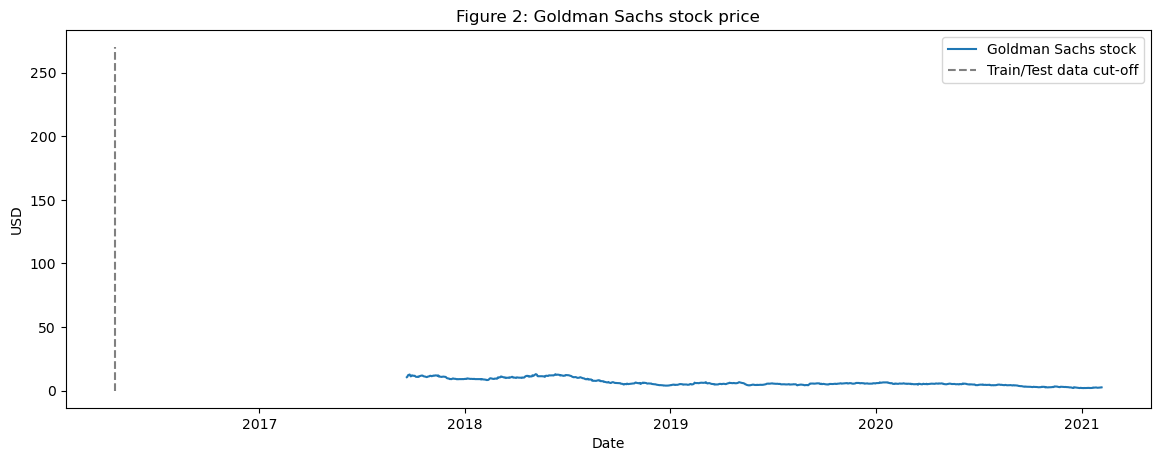

In [10]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['BEST'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [11]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 595. Number of test days: 256.


---
# Technical indicators function
---


## SMA - Simple Moving Average

We've already shown how to create a simple moving average, for a quick review:

Example: Look at <span style="color:red">08-Time-Series-Analysis - 2-EWMA</span>

<span style="color:green">
df['6-month-SMA']=df['Thousands of Passengers'].rolling(window=6).mean() <br>
df['12-month-SMA']=df['Thousands of Passengers'].rolling(window=12).mean()
</span>

---
---

## EWMA - Exponentially-weighted moving average 

We just showed how to calculate the SMA based on some window.However, basic SMA has some "weaknesses".
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behaviour, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

To help fix some of these issues, we can use an EWMA (Exponentially-weighted moving average).

Example:
<span style="color:green">df['EWMA12'] = df['Thousands of Passengers'].ewm(span=12).mean()
</span>

---
---

## Bollinger Bands

We will talk a lot more about financial analysis plots and technical indicators, but here is one worth mentioning!

More info : http://www.investopedia.com/terms/b/bollingerbands.asp

*Developed by John Bollinger, Bollinger Bands® are volatility bands placed above and below a moving average. Volatility is based on the standard deviation, which changes as volatility increases and decreases. The bands automatically widen when volatility increases and narrow when volatility decreases. This dynamic nature of Bollinger Bands also means they can be used on different securities with the standard settings. For signals, Bollinger Bands can be used to identify Tops and Bottoms or to determine the strength of the trend.*

*Bollinger Bands reflect direction with the 20-period SMA and volatility with the upper/lower bands. As such, they can be used to determine if prices are relatively high or low. According to Bollinger, the bands should contain 88-89% of price action, which makes a move outside the bands significant. Technically, prices are relatively high when above the upper band and relatively low when below the lower band. However, relatively high should not be regarded as bearish or as a sell signal. Likewise, relatively low should not be considered bullish or as a buy signal. Prices are high or low for a reason. As with other indicators, Bollinger Bands are not meant to be used as a stand alone tool. *

Example: Look at <span style="color:red">05-Pandas-with-Time-Series - Rolling and Expanding</span>

<span style="color:green">
df['Close: 20 Day Mean'] = df['Close'].rolling(window=20).mean() <br>   
df['Upper'] = df['Close: 20 Day Mean'] + 2*df['Close'].rolling(window=20).std() <br>
df['Lower'] = df['Close: 20 Day Mean'] - 2*df['Close'].rolling(window=20).std() <br>
df[['Close','Close: 20 Day Mean','Upper','Lower']].plot(figsize=(16,6))
</span>

---
---

In [12]:
def get_technical_indicators(dataset):
    #dataset.rename(columns={'GS': 'price'}, inplace=True)
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['price'].rolling(window=21).mean()
    
    # Create MACD 
    # Adjusted with udemy
    df_test = pd.DataFrame(data = np.array(dataset['price']))
    dataset['26ema'] = df_test.ewm(span=26).mean()
    dataset['12ema'] = df_test.ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    # Adjusted with udemy
    dataset['20daymean'] = dataset['price'].rolling(window=20).mean()
    dataset['upper_band'] = dataset['20daymean'] + 2*dataset['price'].rolling(window=20).std()
    dataset['lower_band'] = dataset['20daymean'] - 2*dataset['price'].rolling(window=20).std()
    
    # Create Exponential moving average
    dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['price']-1
    
    return dataset

## Recall technical indicators function

In [13]:
dataset_ex_df.rename(columns={'BEST': 'price'}, inplace=True)
dataset_ex_df.head(3)

,Date,price
0,2017-09-20,10.52
1,2017-09-21,10.89
2,2017-09-22,12.05


In [14]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['price']])

In [15]:
dataset_TI_df

,price,ma7,ma21,26ema,12ema,MACD,20daymean,upper_band,lower_band,ema,momentum
0,10.52,NaN,NaN,10.520000,10.520000,0.000000,NaN,NaN,NaN,10.520000,9.52
1,10.89,NaN,NaN,10.712115,10.720417,0.008301,NaN,NaN,NaN,10.797500,9.89
2,12.05,NaN,NaN,11.192804,11.239353,0.046549,NaN,NaN,NaN,11.664615,11.05
3,12.64,NaN,NaN,11.597377,11.681483,0.084106,NaN,NaN,NaN,12.323000,11.64
4,11.75,NaN,NaN,11.632771,11.700099,0.067328,NaN,NaN,NaN,11.939421,10.75
...,...,...,...,...,...,...,...,...,...,...,...
846,2.27,2.321429,2.153810,2.250628,2.252577,0.001949,2.1595,2.491795,1.827205,2.259217,1.27
847,2.36,2.334286,2.169048,2.258729,2.269103,0.010374,2.1805,2.507430,1.853570,2.326406,1.36
848,2.46,2.337143,2.193810,2.273638,2.298472,0.024834,2.2000,2.545193,1.854807,2.415469,1.46
849,2.42,2.335714,2.210476,2.284480,2.317169,0.032689,2.2220,2.564228,1.879772,2.418490,1.42


In [16]:
dataset_TI_df.insert(loc=0, column='Date', value=list(dataset_ex_df.Date))

In [17]:
dataset_TI_df.iloc[20]

Date          2017-10-18 00:00:00
price                       11.78
ma7                         11.37
ma21                      11.4148
26ema                     11.4092
12ema                     11.4357
MACD                    0.0264573
20daymean                 11.4595
upper_band                12.4437
lower_band                10.4753
ema                       11.7544
momentum                    10.78
Name: 20, dtype: object

In [18]:
dataset_TI_df['log_momentum'] = np.log2(dataset_TI_df['momentum']) 

In [19]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

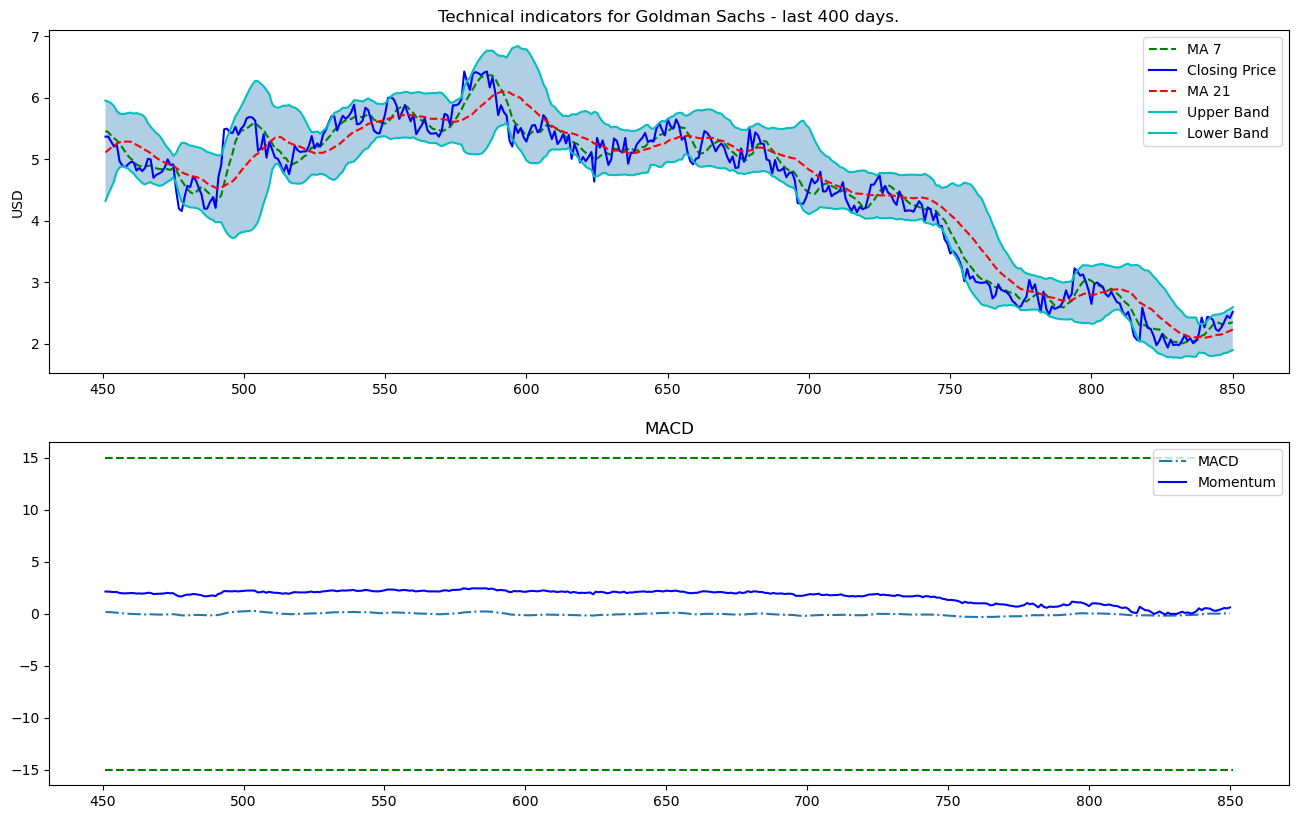

In [20]:
plot_technical_indicators(dataset_TI_df, 400)

# Fourier transforms

In [21]:
data_FT = dataset_ex_df[['Date', 'price']]
data_FT.head(3)

,Date,price
0,2017-09-20,10.52
1,2017-09-21,10.89
2,2017-09-22,12.05


In [22]:
close_fft = np.fft.fft(np.asarray(data_FT['price'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

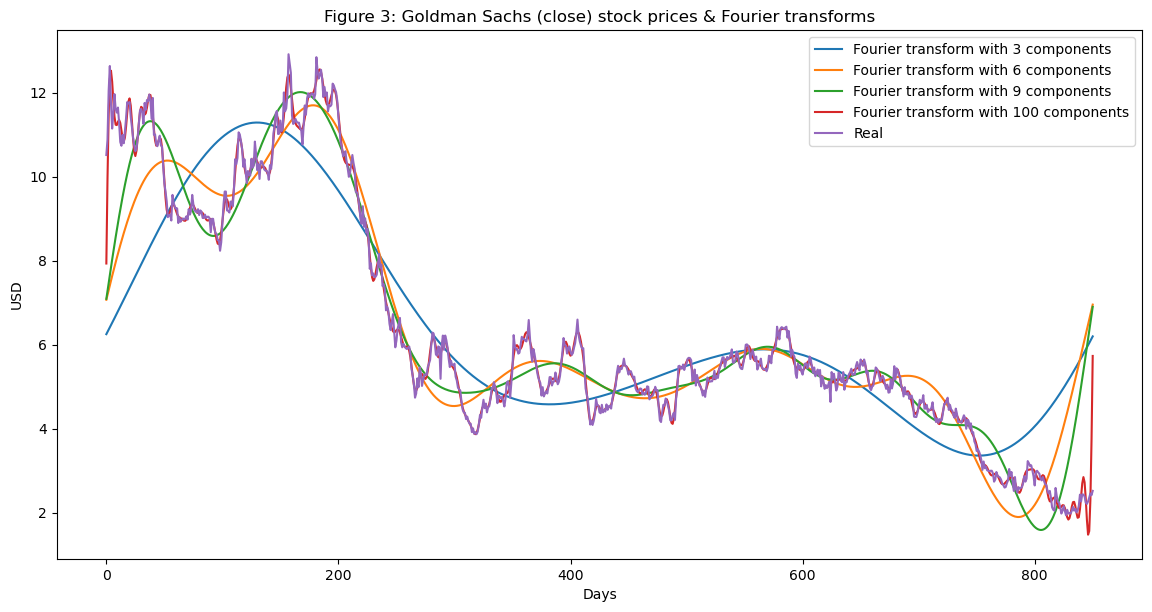

In [23]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [ 3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['price'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [24]:
from collections import deque

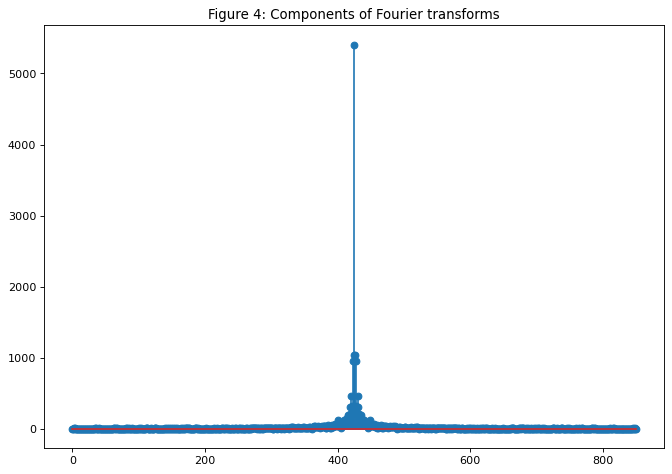

In [25]:
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [26]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

In [27]:
series = data_FT['price']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  850
Model:                 ARIMA(5, 1, 0)   Log Likelihood                  71.735
Method:                       css-mle   S.D. of innovations              0.222
Date:                Sat, 06 Feb 2021   AIC                           -129.470
Time:                        15:48:34   BIC                            -96.253
Sample:                             1   HQIC                          -116.746
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0095      0.007     -1.337      0.181      -0.023       0.004
ar.L1.D.price     0.0003      0.034      0.009      0.993      -0.067       0.068
ar.L2.D.price    -0.0555      0.035     

In [28]:
from pandas.plotting import autocorrelation_plot

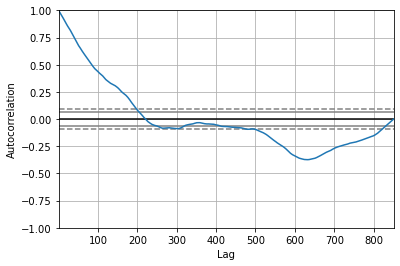

<Figure size 800x560 with 0 Axes>

In [29]:
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [30]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [31]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [32]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.027


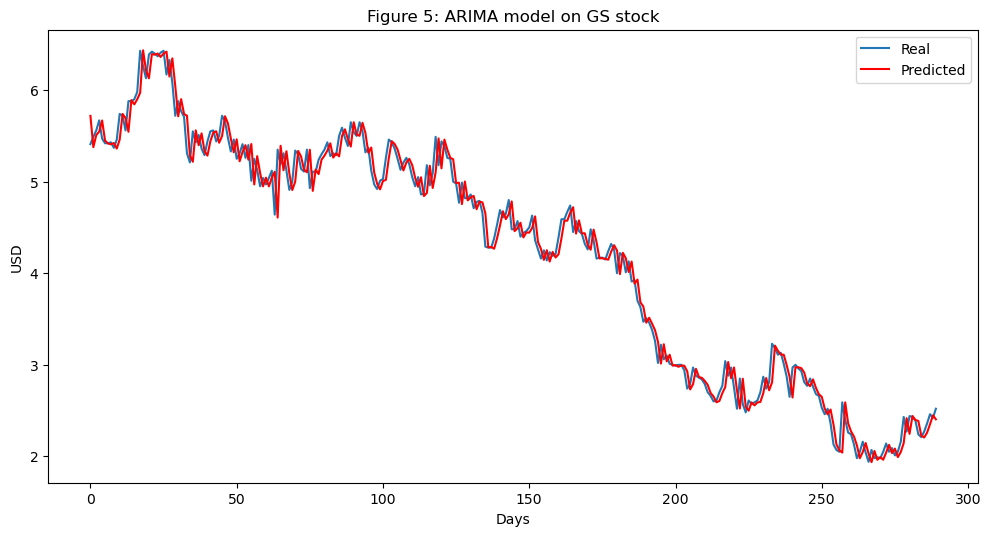

In [33]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

# Add Statistical Checks
## Heteroskedasticity, multicollinearity, serial correlation 

In [34]:
print('Total dataset has {} samples, and {} features.'.format(dataset_TI_df.shape[0], \
                                                              dataset_TI_df.shape[1]))

Total dataset has 851 samples, and 13 features.


In [35]:
dataset_TI_df

,Date,price,ma7,ma21,26ema,12ema,MACD,20daymean,upper_band,lower_band,ema,momentum,log_momentum
0,2017-09-20,10.52,NaN,NaN,10.520000,10.520000,0.000000,NaN,NaN,NaN,10.520000,9.52,3.250962
1,2017-09-21,10.89,NaN,NaN,10.712115,10.720417,0.008301,NaN,NaN,NaN,10.797500,9.89,3.305971
2,2017-09-22,12.05,NaN,NaN,11.192804,11.239353,0.046549,NaN,NaN,NaN,11.664615,11.05,3.465974
3,2017-09-25,12.64,NaN,NaN,11.597377,11.681483,0.084106,NaN,NaN,NaN,12.323000,11.64,3.541019
4,2017-09-26,11.75,NaN,NaN,11.632771,11.700099,0.067328,NaN,NaN,NaN,11.939421,10.75,3.426265
...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,2021-02-01,2.27,2.321429,2.153810,2.250628,2.252577,0.001949,2.1595,2.491795,1.827205,2.259217,1.27,0.344828
847,2021-02-02,2.36,2.334286,2.169048,2.258729,2.269103,0.010374,2.1805,2.507430,1.853570,2.326406,1.36,0.443607
848,2021-02-03,2.46,2.337143,2.193810,2.273638,2.298472,0.024834,2.2000,2.545193,1.854807,2.415469,1.46,0.545968
849,2021-02-04,2.42,2.335714,2.210476,2.284480,2.317169,0.032689,2.2220,2.564228,1.879772,2.418490,1.42,0.505891


In [36]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['price']
    X = data.iloc[:, 2:10]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [37]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

In [38]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
regressor

XGBRegressor(base_score=0.7, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=1, gamma=0.0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [39]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)
xgbModel

XGBRegressor(base_score=0.7, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=24, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
eval_result = regressor.evals_result()

In [41]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

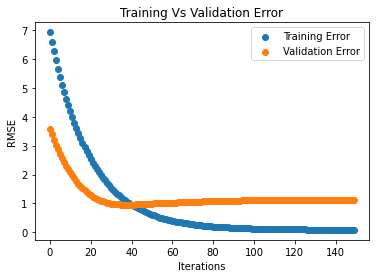

In [42]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

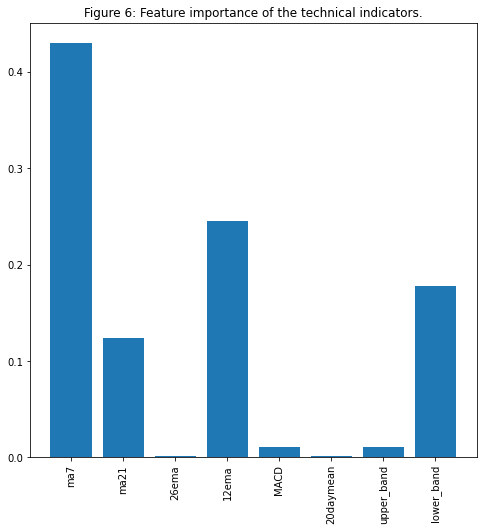

In [43]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

# Extracting high-level features with Stacked Autoencoders

In [ ]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

#  GELU, ReLU, and LeakyReLU

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()

## <span style="color:red">In the future try U-Net</span>